In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [3]:
import os 

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


In [4]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat[lat<=60], lon, indexing='ij')

time_period = 33
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

In [5]:
import skimage

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}
count_model = 0 

for idx,m in enumerate(list(dic_ssp585.keys())):
    print(m, len(dic_ssp585[m].keys()))
    if len(dic_ssp585[m].keys()) > 3 and (count_model < 20):
        count_model += 1
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            dic_reduced_ssp585[m][i] = dic_reduced_ssp585[m][i][:,lat<=60,:]
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]

CanESM5-1 18
CNRM-ESM2-1 5
FIO-ESM-2-0 3
GISS-E2-2-G 5
CMCC-CM2-HR4 0
CNRM-CM6-1 6
INM-CM5-0 1
NESM3 2
E3SM-1-1 1
BCC-CSM2-MR 1
EC-Earth3-LR 0
CESM2-FV2 1
NorCPM1 0
AWI-ESM-1-1-LR 0
MIROC-ES2L 10
MIROC-ES2H 0
CAMS-CSM1-0 2
MPI-ESM1-2-HR 2
IITM-ESM 0
UKESM1-1-LL 0
NorESM2-LM 1
CAS-ESM2-0 2
ICON-ESM-LR 0
E3SM-2-0 0
NorESM1-F 0
AWI-CM-1-1-MR 1
HadGEM3-GC31-MM 4
EC-Earth3-AerChem 0
CanESM5-CanOE 3
EC-Earth3 8
CNRM-CM6-1-HR 1
E3SM-2-0-NARRM 0
KACE-1-0-G 3
MPI-ESM-1-2-HAM 0
IPSL-CM6A-LR-INCA 0
GISS-E2-1-H 10
EC-Earth3-Veg 5
HadGEM3-GC31-LL 4
MCM-UA-1-0 1
CMCC-ESM2 1
MIROC6 50
E3SM-1-0 0
IPSL-CM5A2-INCA 0
GISS-E2-2-H 0
CESM2 5
INM-CM4-8 1
GFDL-CM4 1
FGOALS-g3 4
CESM2-WACCM-FV2 0
GISS-E2-1-G 9
MRI-ESM2-0 6
CESM2-WACCM 3
GISS-E2-1-G-CC 0
KIOST-ESM 1
ACCESS-ESM1-5 40
GISS-E3-G 0
IPSL-CM6A-LR 7
SAM0-UNICON 0
CMCC-CM2-SR5 1
CanESM5 50
TaiESM1 1
ACCESS-CM2 10
CIESM 1
BCC-ESM1 0
GFDL-ESM4 1
MPI-ESM1-2-LR 30
NorESM2-MM 1
FGOALS-f3-L 3
E3SM-1-1-ECA 1
EC-Earth3-Veg-LR 0
UKESM1-0-LL 5


In [6]:
nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    
        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

In [7]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    y_tmp = np.zeros((len(dic_reduced_ssp585[m].keys()),time_period, lat_size*lon_size))
    
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):

        y_tmp[idx_i,:,:] = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[idx_i,:,nan_idx] = float('nan')
           
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = y_tmp[idx_i,:,:] - mean_ref_ensemble

/tmp/ipykernel_3106/630921707.py:18: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
/tmp/ipykernel_3106/630921707.py:20: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())


In [8]:
# compute the forced response
dic_forced_response_ssp585 = dict({})
dic_forced_response_ssp585_tmp = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_spatial_ensemble = y_tmp/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += y_tmp/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):              
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)

/tmp/ipykernel_3106/852978578.py:19: RuntimeWarning: Mean of empty slice
  dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)


In [9]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        x_predictor[m][i] = dic_processed_ssp585[m][i]
        x_predictor[m][i][:,nan_idx] = float('nan')

        y_forced_response[m][i] = dic_forced_response_ssp585[m][i]
        y_forced_response[m][i][:,nan_idx] = float('nan')

In [10]:
# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(x_predictor.keys()):
    variance_processed_ssp585[m] = {}
    arr_tmp = np.zeros((len(x_predictor[m].keys()),time_period,lon_size*lat_size))
    
    for idx_i, i in enumerate(list(x_predictor[m].keys())):
        arr_tmp[idx_i,:,:] = x_predictor[m][i]

    # compute mean across the runs in each grid cell 
    arr_tmp_mean = np.mean(arr_tmp,axis=0)

    # comute the variance value 
    arr_tmp_values = np.zeros((len(x_predictor[m].keys()),time_period,lon_size*lat_size))
    for idx_i, i in enumerate(x_predictor[m].keys()):
        arr_tmp_values[idx_i,:,:] = (x_predictor[m][i] - arr_tmp_mean)**2

    # variance is defines for each grid cell
    variance_processed_ssp585[m] = np.mean(arr_tmp_values,axis=0)

In [11]:
y_forced_response_concatenate = {}
x_predictor_concatenate = {}
var_concatenate = {}
count_x = 0


for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response_concatenate[m] = 0
    x_predictor_concatenate[m] = 0
    var_concatenate[m] = 0

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        count_x += len(dic_processed_ssp585[m].keys())*33
        
        if idx_i ==0:
            y_forced_response_concatenate[m] = dic_forced_response_ssp585[m][i]
            x_predictor_concatenate[m] = dic_processed_ssp585[m][i]
            var_concatenate[m] = variance_processed_ssp585[m]
        else:
            y_forced_response_concatenate[m] = np.concatenate([y_forced_response_concatenate[m],dic_forced_response_ssp585[m][i]])
            x_predictor_concatenate[m] = np.concatenate([x_predictor_concatenate[m], dic_processed_ssp585[m][i]],axis=0)  
            var_concatenate[m] = np.concatenate([var_concatenate[m], variance_processed_ssp585[m]],axis=0)

    var_concatenate[m][:,nan_idx] = float('nan')
    x_predictor_concatenate[m][:,nan_idx] = float('nan')
    y_forced_response_concatenate[m][:,nan_idx] = float('nan')

In [12]:
# Data preprocessing
x_train = {}
y_train = {}
var_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = torch.nan_to_num(torch.from_numpy(x_predictor_concatenate[m])).to(torch.float64)
    y_train[m] = torch.nan_to_num(torch.from_numpy(y_forced_response_concatenate[m])).to(torch.float64)
    var_train[m] = torch.nan_to_num(torch.from_numpy(var_concatenate[m])).to(torch.float64)

In [13]:
# update the variance by batch
var_train_tmp = torch.zeros(len(dic_reduced_ssp585.keys()),time_period,lat_size*lon_size)

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    var_train_tmp[idx_m,:,:] = var_train[m][:time_period,:]

In [14]:
# We want X in R^{grid x runs*time steps}
x_tmp = torch.zeros(count_x, lat_size*lon_size)
y_tmp = torch.zeros(count_x, lat_size*lon_size)

# m0 = 'CNRM-ESM2-1'
m0 = 'CanESM5'
x_test = torch.zeros(len(x_predictor[m0].keys())*time_period, lat_size*lon_size)
y_test = torch.zeros(len(x_predictor[m0].keys())*time_period, lat_size*lon_size)

count_tmp =0

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):

    if m != m0:

        if count_tmp ==0:
            x_tmp[:x_train[m].shape[0],:] = x_train[m]/torch.sqrt(var_train[m])
            y_tmp[:y_train[m].shape[0],:] = y_train[m]/torch.sqrt(var_train[m])
            count_tmp = x_train[m].shape[0]
    
        else:
            x_tmp[count_tmp:count_tmp+x_train[m].shape[0],:] = x_train[m]/torch.sqrt(var_train[m])
            y_tmp[count_tmp:count_tmp+y_train[m].shape[0],:] = y_train[m]/torch.sqrt(var_train[m])
            count_tmp = x_train[m].shape[0]

    else: 
        for idx_r, r in enumerate(dic_reduced_ssp585[m].keys()):
            x_test[idx_r*time_period:(idx_r+1)*time_period,:] = torch.nan_to_num(torch.from_numpy(x_predictor[m][r]))/torch.sqrt(torch.mean(var_train_tmp,axis=0))
            y_test[idx_r*time_period:(idx_r+1)*time_period,:] = torch.nan_to_num(torch.from_numpy(y_forced_response[m][r]))/torch.sqrt(torch.mean(var_train_tmp,axis=0))

In [15]:
# # We want X in R^{grid x runs*time steps}
# x_tmp = torch.zeros(count_x, lat_size*lon_size)
# y_tmp = torch.zeros(count_x, lat_size*lon_size)

# m0 = 'CNRM-ESM2-1'
# x_test = torch.zeros(len(x_predictor[m0].keys())*time_period, lat_size*lon_size)
# y_test = torch.zeros(len(x_predictor[m0].keys())*time_period, lat_size*lon_size)

# count_tmp =0

# for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
#     if m != m0:

#         if count_tmp ==0:
#             x_tmp[:x_train[m].shape[0],:] = x_train[m]
#             y_tmp[:y_train[m].shape[0],:] = y_train[m]
#             count_tmp = x_train[m].shape[0]
    
#         else:
#             x_tmp[count_tmp:count_tmp+x_train[m].shape[0],:] = x_train[m]
#             y_tmp[count_tmp:count_tmp+y_train[m].shape[0],:] = y_train[m]
#             count_tmp = x_train[m].shape[0]

#     else: 
#         x_test = x_train[m]
#         y_test = y_train[m]

# 1- Optimization problem here: 
# $\min_{W} \Vert Y - X W \Vert_F^2 + \lambda \Vert W \Vert_F^2$

In [16]:
def RRR_closed_form(X, Y, rank, reg=1.0):
    """
    Computes the closed-form solution for reduced rank regression.
    
    Args:
        X (torch.Tensor): Predictor matrix of shape (n, p).
        Y (torch.Tensor): Response matrix of shape (n, q).
        rank (int): Desired rank for the approximation.

    Returns:
        U (torch.Tensor): Low-rank predictor coefficients of shape (p, rank).
        V (torch.Tensor): Low-rank response coefficients of shape (q, rank).
    """

    # compute Penroe Morose pseudo inverse of X^T @ X
    P = torch.linalg.inv(X.T @ X + reg * torch.eye(X.shape[1]))
    print("The inverse (or Penroe Morose) has been computed")
    
    # compute ordinary least square solution 
    W_ols = P @ X.T @ Y
    
    # compute SVD decomposition of X @ W_ols
    U, S, Vh = torch.linalg.svd(X @ W_ols, full_matrices=False)
    
    # Truncate to the desired rank
    U_r = U[:, :rank]            # (p, rank)
    S_r = torch.diag(S[:rank])   # (rank, rank)
    V_r = Vh[:rank, :].T         # (q, rank)

    # compute regressor
    W_rrr = W_ols @ V_r @ V_r.T

    return W_rrr

## Compute the regressor $W_{rrr}$

In [29]:
# choose the rank 
r = 10

# compute the regressor matrix
W_rrr = RRR_closed_form(x_tmp[:,notnan_idx], y_tmp[:,notnan_idx], r, reg=10.0)

The inverse (or Penroe Morose) has been computed


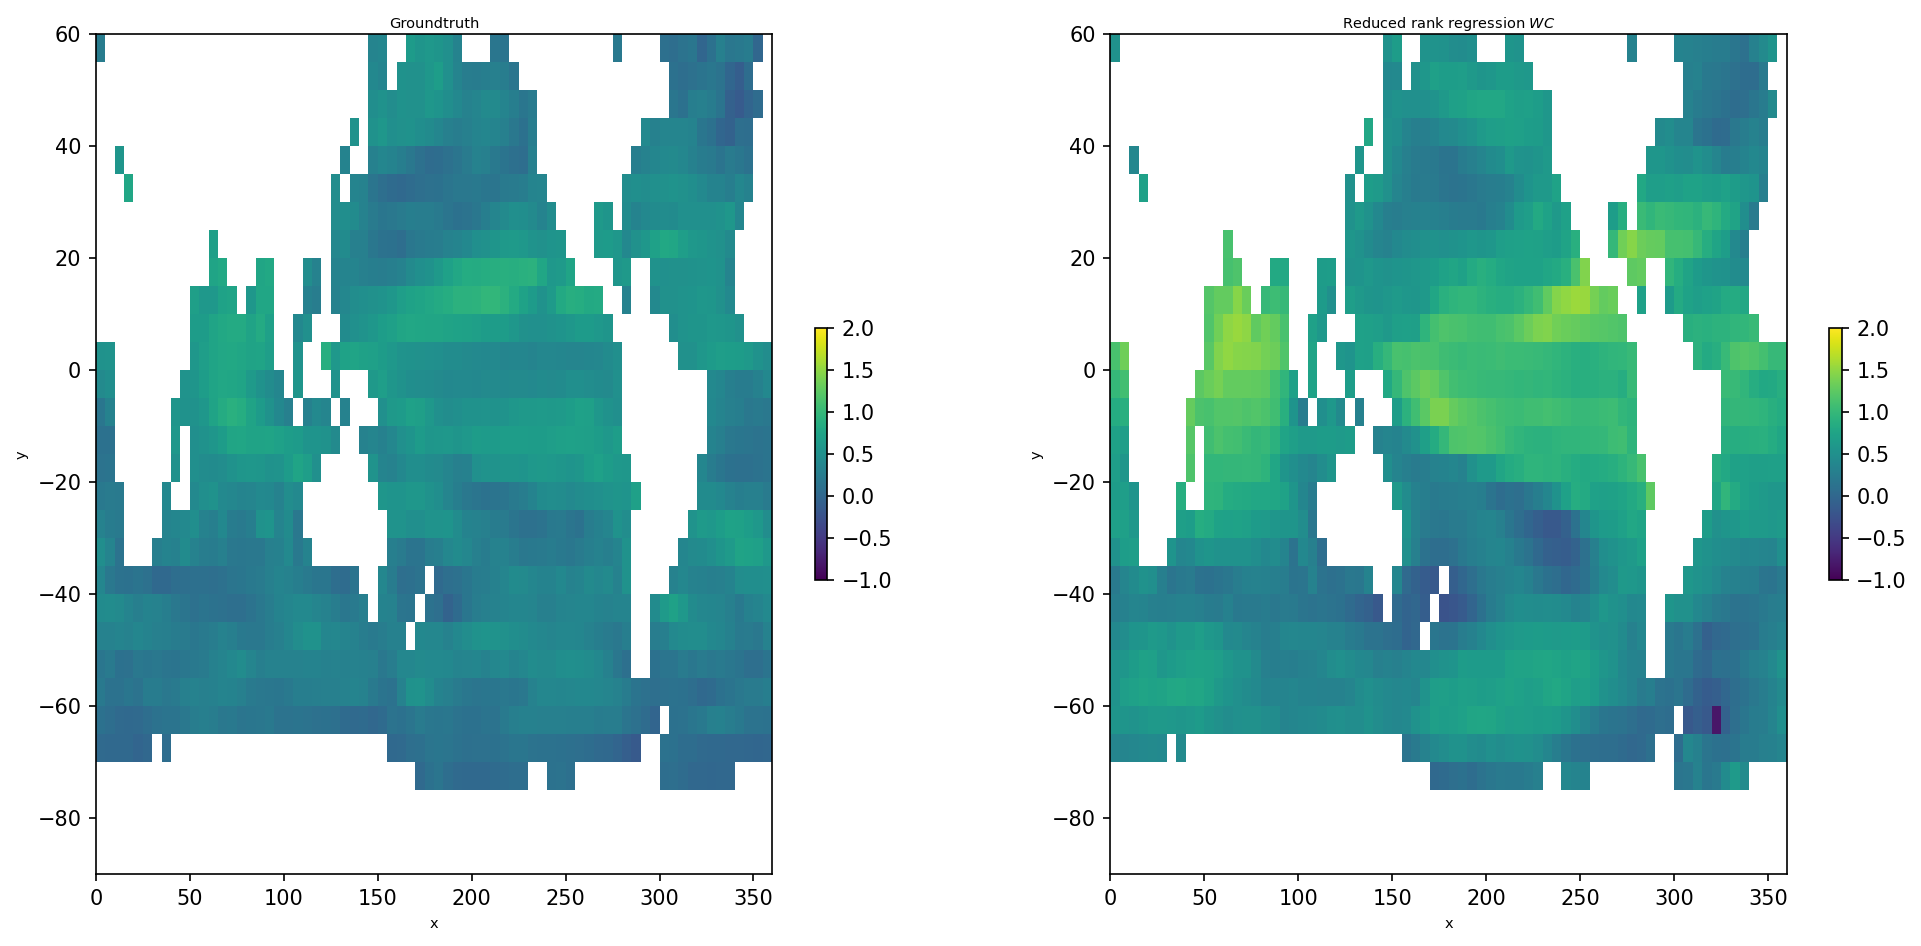

In [30]:
# predictions
y_pred = torch.ones_like(x_test).to(torch.float64)
y_pred[:,nan_idx] = float('nan')
y_pred[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W_rrr.to(torch.float64)

# display predictions and target for the first run
# index of the run  
i = 1
y_target = y_test[time_period*i:time_period*(i+1),:]
y_target_pred = y_pred[:time_period,:]


# display Y map for a given model m0
time_idx = 20
y_target[:,nan_idx] = float('nan')
y_target_pred[:,nan_idx] = float('nan')

y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[time_idx,:].detach().numpy().reshape(lat_size,lon_size)


plt.close('all')
fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 2, 2)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

plt.show()

## display the predicted observations using gif animation 

In [31]:
from matplotlib import animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()


plt.close('all')
fig0 = plt.figure()

ax0 = fig0.add_subplot(1, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(1, 2, 2)        
ax1.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

y_to_plot_target = y_target[0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[0,:].detach().numpy().reshape(lat_size,lon_size)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)


def animate_maps(i):

    y_to_plot_target = y_target[i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred = y_target_pred[i,:].detach().numpy().reshape(lat_size,lon_size)

    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
    im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
    
plt.colorbar(im0, ax=ax0, shrink=0.3)
plt.colorbar(im1, ax=ax1, shrink=0.3)
plt.tight_layout()
animation.FuncAnimation(fig0, animate_maps, frames=time_period)

In [20]:
##### TO DO

# - try to use different regularization

# 2- Optimization problem here: 
# $\min_{U,V} \Vert Y - X U V \Vert_F^2 + \lambda \Vert U \Vert_F^2 + \mu \Vert V \Vert_F^2$

In [21]:
# def reduced_rank_regression_regularized(X, Y, rank, lambda_reg=1e-4, mu_reg=1e-4, max_iter=100, tol=1e-6):
#     """
#     Solves the reduced rank regression problem with L2 regularization.
    
#     Args:
#         X (torch.Tensor): Predictor matrix (n, p).
#         Y (torch.Tensor): Response matrix (n, q).
#         rank (int): Desired rank for the solution.
#         lambda_reg (float): Regularization parameter for U.
#         mu_reg (float): Regularization parameter for V.
#         max_iter (int): Maximum number of iterations.
#         tol (float): Convergence tolerance.

#     Returns:
#         U (torch.Tensor): Predictor coefficients (p, rank).
#         V (torch.Tensor): Response coefficients (q, rank).
#     """
#     # Initialize V using SVD
#     M = X.T @ Y
#     U_init, _, Vt_init = torch.linalg.svd(M, full_matrices=False)
#     V = Vt_init[:rank, :].T  # Initialize V (q, rank)
    
#     for _ in range(max_iter):
#         # Save previous V for convergence check
#         V_prev = V.clone()
        
#         # Update U
#         XtX = X.T @ X
#         XtYV = X.T @ Y @ V
#         VtV_inv = torch.linalg.inv(V.T @ V)
#         U = torch.linalg.solve(XtX + lambda_reg * torch.eye(XtX.size(0)), XtYV @ VtV_inv)
        
#         # Update V
#         XU = X @ U
#         YtXU = Y.T @ XU
#         XtXU = XU.T @ XU
#         V = torch.linalg.solve(XtXU + mu_reg * torch.eye(XtXU.size(0)), YtXU.T).T

#         if _%5 ==0:
#             print("Loss: ", (torch.norm(Y - X @ U @ V.T, p='fro')**2 + lambda_reg*torch.norm(U,p='fro')**2 + mu_reg*torch.norm(V,p='fro')**2).item())
        
#         # Check convergence
#         if torch.norm(V - V_prev) < tol:
#             break
    
#     return U, V

In [22]:
# U,V = reduced_rank_regression_regularized(x_tmp[:,notnan_idx], y_tmp[:,notnan_idx], r, lambda_reg=10.0, mu_reg=10.0, max_iter=100, tol=1e-4)

In [23]:
# y_pred = torch.ones_like(x_test).to(torch.float64)
# y_pred[:,nan_idx] = float('nan')
# y_pred[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ U.to(torch.float64) @ V.T.to(torch.float64)

# y_target = y_test[:33,:]
# y_target_pred = y_pred[:33,:]


# # display Y map for a given model m0
# time_idx = 25 
# y_target[:,nan_idx] = float('nan')
# y_target_pred[:,nan_idx] = float('nan')

# y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
# y_to_plot_pred = y_target_pred[time_idx,:].detach().numpy().reshape(lat_size,lon_size)


# plt.close('all')
# fig0 = plt.figure(figsize=(16,16))           

# ax0 = fig0.add_subplot(2, 2, 1)        
# ax0.set_title(r'Groundtruth', size=7,pad=3.0)
# im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
# plt.colorbar(im0, ax=ax0, shrink=0.3)
# ax0.set_xlabel(r'x', size=7)
# ax0.set_ylabel(r'y', size=7)

# ax0 = fig0.add_subplot(2, 2, 2)        
# ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
# im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
# plt.colorbar(im0, ax=ax0, shrink=0.3)
# ax0.set_xlabel(r'x', size=7)
# ax0.set_ylabel(r'y', size=7)

# plt.show()

# Define pytorch model and optimize using Adam

In [24]:
# # Define the Low-Rank Regression Model
# class LowRankRegression(nn.Module):
#     def __init__(self, input_dim, output_dim, rank):
#         """
#         Args:
#             input_dim: Number of input features
#             output_dim: Number of output features
#             rank: Rank for the low-rank decomposition
#         """
#         super(LowRankRegression, self).__init__()
        
#         # Low-rank factor matrices
#         self.U = nn.Parameter(torch.randn(input_dim, rank).to(torch.float64))
#         self.V = nn.Parameter(torch.randn(output_dim, rank).to(torch.float64))
        
#     def forward(self, X):
#         """
#         Forward pass: X -> Output
#         Args:
#             X: Input data of shape (batch_size, input_dim)
#         Returns:
#             Predicted output of shape (batch_size, output_dim)
#         """
#         W = self.U @ self.V.T  # Low-rank approximation of W
#         return X @ W

# # Training the Model
# def train_model(model, X, Y, lambda_=1.0 ,lr=0.01, n_epochs=100):
#     """
#     Train the low-rank regression model.
#     Args:
#         model: Low-rank regression model
#         X: Input data
#         Y: Target outputs
#         lr: Learning rate
#         n_epochs: Number of epochs
#     Returns:
#         Trained model
#     """
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     loss_fn = nn.MSELoss()
#     for epoch in range(n_epochs):
#         model.train()
#         optimizer.zero_grad()
#         predictions = model(X)
#         loss = loss_fn(predictions[:,notnan_idx], Y[:,notnan_idx]) + lambda_* torch.norm(model.U[notnan_idx,:],p='fro')**2 + lambda_ *torch.norm(model.V[notnan_idx,:],p='fro')**2
#         loss.backward()
#         optimizer.step()
#         if (epoch + 1) % 10 == 0:
#             print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss.item():.4f}")
#     return model

In [25]:
n_samples = count_x
n_predictors = lat_size*lon_size
n_responses = lat_size*lon_size
rank = 3

lambda_ = 10.0

# Initialize and train the model
# model = LowRankRegression(input_dim=n_predictors, output_dim=n_predictors, rank=rank)
# trained_model = train_model(model, x_tmp.to(torch.float64), y_tmp.to(torch.float64), lr=0.01, n_epochs=1000)

In [26]:
# y_pred = model(x_test)
# y_target = y_test[:33,:]
# y_target_pred = y_pred[:33,:]

# # display Y map for a given model m0
# time_idx = 20
# y_target[:,nan_idx] = float('nan')
# y_target_pred[:,nan_idx] = float('nan')

# y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
# y_to_plot_pred = y_target_pred[time_idx,:].detach().numpy().reshape(lat_size,lon_size)

# fig0 = plt.figure(figsize=(16,16))           

# ax0 = fig0.add_subplot(2, 2, 1)        
# ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
# im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target)
# plt.colorbar(im0, ax=ax0, shrink=0.3)
# ax0.set_xlabel(r'x', size=7)
# ax0.set_ylabel(r'y', size=7)

# ax0 = fig0.add_subplot(2, 2, 2)        
# ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
# im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-0.5,vmax=0.5)
# plt.colorbar(im0, ax=ax0, shrink=0.3)
# ax0.set_xlabel(r'x', size=7)
# ax0.set_ylabel(r'y', size=7)